In [1]:
#add a slider
#L values from 0.1 to 3
import numpy as np
import matplotlib.pyplot as plt
%pip install ipywidgets --quiet
from ipywidgets import interact, FloatSlider, Layout

#ignore error
np.seterr(divide='ignore', invalid='ignore')

#Wavelength
lam = 1;
#Phase constant
B = 2*np.pi/lam;
t = np.linspace(0, 2*np.pi, 360);

def my_function(x):
    plt.style.use('default')
    #Dipole antenna
    L = x*lam;
    #Far-field pattern equation    
    E = np.abs((np.cos(B*L/2*np.cos(t))-np.cos(B*L/2))/np.sin(t));
    #plot figure
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, polar=True)
    ax.set_rlim(0,3)
    ax.set_yticklabels([])
    ax.plot(t,E)
    plt.show()

#create a slider
style = {'description_width': 'initial'}          #to fit in the long description
interact(my_function, x=FloatSlider(
    value=1.0,
    min=0.1,
    max=3.0,
    step=0.01,
    description='Elektrische Länge (L/λ):',
    style=style,
    layout=Layout(width='50%', height='50px')));

Note: you may need to restart the kernel to use updated packages.


interactive(children=(FloatSlider(value=1.0, description='Elektrische Länge (L/λ):', layout=Layout(height='50p…

In [1]:
#Add in slider
%pip install ipywidgets --quiet
%pip install plotly --quiet
%pip install nbformat --quiet
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact
from ipywidgets import interact, FloatSlider, Layout
from plotly.subplots import make_subplots

# Define constants
lambda_ = 1.0  # Wavelength (in meters)
k = 2 * np.pi / lambda_  # Wave number
theta = np.linspace(0, 2 * np.pi, 360)  # Azimuthal angle
phi = np.linspace(0, np.pi, 180)  # Elevation angle
theta_grid, phi_grid = np.meshgrid(theta, phi)

def plot_dipole(x):
    # Far-field pattern for a finite dipole antenna
    L = x*lambda_
    E = np.abs((np.cos(k*L/2*np.cos(phi_grid))-np.cos(k*L/2))/np.sin(phi_grid));
    
    # Convert spherical coordinates to Cartesian coordinates
    X = E * np.sin(phi_grid) * np.cos(theta_grid)
    Y = E * np.sin(phi_grid) * np.sin(theta_grid)
    Z = E * np.cos(phi_grid)
    
    # Compute 2D polar plot data (average E over azimuth angles)
    E_polar = np.abs((np.cos(k*L/2*np.cos(theta))-np.cos(k*L/2))/np.sin(theta))

    # Create a subplot layout for the polar plot on the left and 3D plot on the right
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'polar'}, {'type': 'surface'}]],
    )

    # Add the polar plot
    fig.add_trace(
        go.Scatterpolar(
            r=E_polar,  # Radial coordinate
            theta=np.degrees(theta),  # Convert phi to degrees
            mode='lines',
            line=dict(color='blue'),
            name='Strahlungsdiagramm im Fernfeld'
        ),
        row=1, col=1
    )

    # Add the 3D surface plot
    fig.add_trace(
        go.Surface(
            x=Z, y=Y, z=X,
            surfacecolor=E,
            colorscale='Viridis',
            colorbar=dict(title='E (Fernfeld)'),
            opacity=0.8
        ),
        row=1, col=2
    )

    # Update layout for better visualization
    fig.update_layout(
        title=f'Strahlungsdiagramm im Fernfeld: L = {L:.2f} λ',
        height=500,
        showlegend=False,
        polar = dict(
            radialaxis = dict(range=[0, 3], showticklabels=False, ticks=''),  #don't show polar label and fix range
#            angularaxis = dict(showticklabels=False, ticks='')
        ),
        scene=dict(
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False),
            zaxis=dict(showticklabels=False),
    )
    )

    # Show the plot
    fig.show()

# Use interact to create a slider for L
#interact(plot_dipole, x=(0.10, 3.00, 0.01))
#create a slider
style = {'description_width': 'initial'}          #to fit in the long description
interact(plot_dipole, x=FloatSlider(
    value=1.0,
    min=0.1,
    max=3.0,
    step=0.01,
    description='Elektrische Länge (L/λ):',
    style=style,
    layout=Layout(width='80%', height='50px')));

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


interactive(children=(FloatSlider(value=1.0, description='Elektrische Länge (L/λ):', layout=Layout(height='50p…

Note: you may need to restart the kernel to use updated packages.


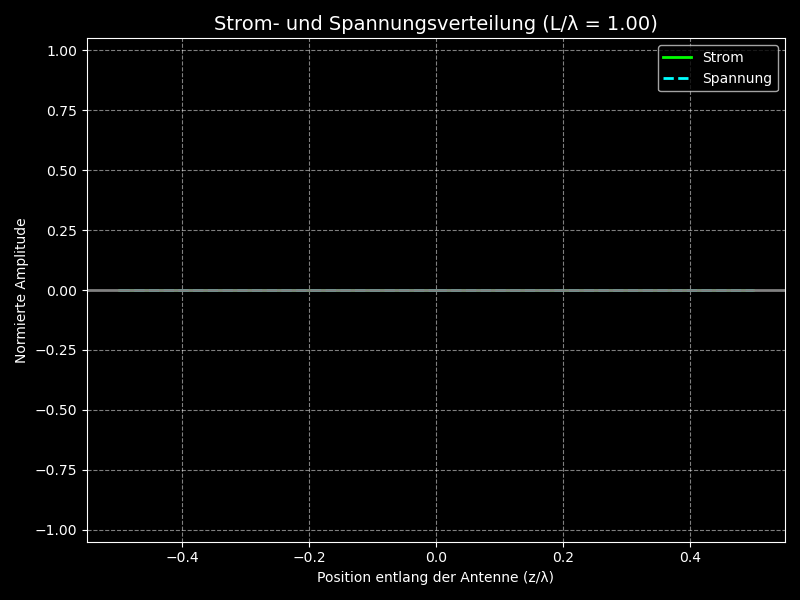

In [1]:
%pip install ipympl --quiet
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from ipywidgets import FloatSlider, Layout, Output, VBox
import matplotlib.animation as animation
import pandas as pd

# ----------------------------
# Laden und Bereinigen der Antennendaten
# ----------------------------
df = pd.read_csv('Imp_Direc_ld100.csv')
df.replace({'inf': np.inf, 'na': np.nan, '-': np.nan, 'j': np.nan}, inplace=True)

for col in ['Electrical_Length', 'Resistance', 'Reactance', 'Directivity']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('Electrical_Length').reset_index(drop=True)

lengths = df['Electrical_Length'].values
resistances = df['Resistance'].values
reactances = df['Reactance'].values
directivities = df['Directivity'].values

def get_antenna_params(l_norm):
    if l_norm in lengths:
        idx = np.where(lengths == l_norm)[0][0]
        R, X, D = resistances[idx], reactances[idx], directivities[idx]
    else:
        valid_mask = np.isfinite(resistances) & np.isfinite(reactances) & np.isfinite(directivities)
        R = np.interp(l_norm, lengths[valid_mask], resistances[valid_mask])
        X = np.interp(l_norm, lengths[valid_mask], reactances[valid_mask])
        D = np.interp(l_norm, lengths[valid_mask], directivities[valid_mask])
    return R, X, D

# ----------------------------
# Globals and widget output
# ----------------------------
current_l_norm = 1.0   # the value the slider controls; read by the animation
output_text = Output()

# ----------------------------
# Initial figure & artists (created once)
# ----------------------------
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))
fig.canvas.header_visible = False

# initial z for L = current_l_norm
eps = 1e-9
z_left = np.linspace(-current_l_norm/2, -eps, 250)
z_right = np.linspace(eps, current_l_norm/2, 250)

# create line artists for left & right halves
current_line_left,  = ax.plot(z_left, np.zeros_like(z_left), color='lime', linewidth=2, label='Strom')
current_line_right, = ax.plot(z_right, np.zeros_like(z_right), color='lime', linewidth=2)

voltage_line_left,  = ax.plot(z_left, np.zeros_like(z_left), color='cyan', linewidth=2, linestyle='--', label='Spannung')
voltage_line_right, = ax.plot(z_right, np.zeros_like(z_right), color='cyan', linewidth=2, linestyle='--')

ax.set_ylim([-1.05, 1.05])
ax.set_xlabel('Position entlang der Antenne (z/λ)')
ax.set_ylabel('Normierte Amplitude')
ax.grid(True, linestyle='--', alpha=0.5)
ax.axhline(0, color='gray', linewidth=2.0)
title_text = ax.set_title(f'Strom- und Spannungsverteilung (L/λ = {current_l_norm:.2f})', fontsize=14)
ax.legend()
plt.tight_layout()

# store fill collection references so we can remove them each frame
fills = []

# ----------------------------
# Animation update (reads current_l_norm)
# ----------------------------
def update_animation_frame(frame, num_frames):
    global fills

    l_norm = current_l_norm
    omega_t = 2 * np.pi * (frame / num_frames)

    # recompute z for this l_norm (avoid exact zero)
    eps = 1e-9
    z_left = np.linspace(-l_norm/2, -eps, 250)
    z_right = np.linspace(eps, l_norm/2, 250)

    # compute current and voltage (left & right)
    curr_L = np.sin(2 * np.pi * (l_norm/2 - np.abs(z_left))) * np.cos(omega_t)
    curr_R = np.sin(2 * np.pi * (l_norm/2 - np.abs(z_right))) * np.cos(omega_t)

    volt_L = np.cos(2 * np.pi * (l_norm/2 - np.abs(z_left))) * np.sign(z_left) * np.sin(omega_t)
    volt_R = np.cos(2 * np.pi * (l_norm/2 - np.abs(z_right))) * np.sign(z_right) * np.sin(omega_t)

    # update line x and y data
    current_line_left.set_xdata(z_left);  current_line_left.set_ydata(curr_L)
    current_line_right.set_xdata(z_right); current_line_right.set_ydata(curr_R)

    voltage_line_left.set_xdata(z_left);  voltage_line_left.set_ydata(volt_L)
    voltage_line_right.set_xdata(z_right); voltage_line_right.set_ydata(-volt_R)

    # remove previous fills
    for coll in fills:
        try:
            coll.remove()
        except Exception:
            pass
    fills = []

    # add new fills (left & right for current and voltage)
    fills.append(ax.fill_between(z_left, 0, curr_L, color='lime', alpha=0.3))
    fills.append(ax.fill_between(z_right, 0, curr_R, color='lime', alpha=0.3))
    fills.append(ax.fill_between(z_left, 0, volt_L, color='cyan', alpha=0.3))
    fills.append(ax.fill_between(z_right, 0, -volt_R, color='cyan', alpha=0.3))

    # update axes limits & title so it reflects new l_norm
    ax.set_xlim(-l_norm/2, l_norm/2)
    title_text.set_text(f'Strom- und Spannungsverteilung (L/λ = {l_norm:.2f})')

    return (current_line_left, current_line_right,
            voltage_line_left, voltage_line_right) + tuple(fills)

# ----------------------------
# Slider callback: update current_l_norm and the info box
# ----------------------------
def slider_changed(change):
    global current_l_norm
    # change dict contains 'new'
    if isinstance(change, dict) and 'new' in change:
        current_l_norm = float(change['new'])
    else:
        current_l_norm = float(slider.value)

    # update the output info immediately when slider is released
    R, X, D = get_antenna_params(current_l_norm)
    def fmt(v, unit=""):
        if np.isnan(v): return "nicht definiert"
        if np.isinf(v): return "∞"
        return f"{v:.1f} {unit}".strip()

    with output_text:
        output_text.clear_output()
        #print(f"Elektrische Länge: {current_l_norm:.2f} λ")
        print(f"Widerstand: {fmt(R, 'Ω')}")
        print(f"Reaktanz: {fmt(X, 'Ω')}")
        print(f"Direktivität: {fmt(D, 'dBi')}")
        print("⚠️ Gilt nur für sehr dünne Dipolantennen (L/d = 100).")

# ----------------------------
# Schieberegler und Layout
# ----------------------------
style = {'description_width': 'initial'}

slider = FloatSlider(
    value=current_l_norm, min=0.1, max=3.0, step=0.01,
    description='Elektrische Länge (L/λ):', style=style,
    continuous_update=False,   # updates on release
    layout=Layout(width='80%')
)
slider.observe(slider_changed, names='value')

ui = VBox([slider, output_text])
display(ui)

# initialize info box
slider_changed({'new': current_l_norm})

# ----------------------------
# Create the animation once (reads current_l_norm each frame)
# ----------------------------
ani = animation.FuncAnimation(fig, update_animation_frame, fargs=(200,),
                              frames=200, interval=50, blit=False, repeat=True)

plt.show()